# Ensambles - Boosting

A lo largo del notebook vamos a trabajar con el siguiente dataset, que es el que utilizamos en los encuentros anteriores:

https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Si ya te sientes seguro/a, puedes utilizar un clasificador AdaBoost de Scikit-Learn sobre este dataset sin seguir los pasos que te dejamos más abajo. También, puedes seguirlos, pero borrando las pistas que te dejamos. ¡Anímate a probar más cosas solo/a!

### Carga de datos

Volvemos a cargas las librerías, importar el dataset y limpiarlo.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv("DS_Bitácora_27_Weather.csv")
# Columnas con muchos NaNs
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location'
                         #,'RISK_MM'
                         ,'Date']
data = data.drop(columns=columnas_descartables)
data = data.dropna()

# Columnas con variables categoricas
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)

# Variables correlacionadas
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

# Mapeo
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})

In [3]:
data.head(5)

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  WindSpeed3pm  \
0     13.4     22.9       0.6           44.0          20.0          24.0   
1      7.4     25.1       0.0           44.0           4.0          22.0   
2     12.9     25.7       0.0           46.0          19.0          26.0   
3      9.2     28.0       0.0           24.0          11.0           9.0   
4     17.5     32.3       1.0           41.0           7.0          20.0   

   Humidity9am  Humidity3pm  Pressure3pm  Temp9am  RainTomorrow  
0         71.0         22.0       1007.1     16.9             0  
1         44.0         25.0       1007.8     17.2             0  
2         38.0         30.0       1008.7     21.0             0  
3         45.0         16.0       1012.8     18.1             0  
4         82.0         33.0       1006.0     17.8             0

## 1. AdaBoost

El objetivo de boosting es generar un modelo fuerte a partir de entrenar sucesivamente modelos débiles y combinar sus resultados. La idea es que cada modelo débil que agrego se enfoque en las instancias que fueron clasificadas erroneamente hasta el momento. Empecemos por decidir sobre que fetures del dataset vamos a trabajar (si trabajan sobre 2, luego podrán visualizar):

In [4]:
# Elegimos sobre que coolumnas queremos trabajar

columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
y = data.RainTomorrow

# X = data.drop(columns = 'RainTomorrow')
# y = data.RainTomorrow

# Separamos los datos en train y test (held-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Recordemos que este tipo de ensamble se enfoca en mejorar el sesgo de los modelos individuales a partir de los cuales está construido, por lo cual se suele usar modelos de alto sesgo y baja varianza.

1. Empiece por importar el clasificador AdaBoostClassifier y el modelo que usaremos como estimador debil, el DecisionTreeClassifier

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

2. Defina el modelo de manera que utilice 150 árboles de profundidad veinte (20). Luego probaremos que sucede para mayores profundidades.

In [6]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20)
                             ,algorithm='SAMME'
                             ,n_estimators=150
                            )
# Entrenamos el modelo
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=150)

3. Calcule el error sobre el training set y sobre el test set. En base a estos resultados, ¿les parece que este ensamble está inclinado hacia el sesgo o hacia la varianza?

In [7]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.8631700127772085
0.8035303146584805


4. Veamos ahora cómo es la distribución de los pesos de cada árbol. Para esto vamos a graficar el número del árbol vs el peso que el algoritmo le está dando para la clasificación final. Además, graficaremos también el accuracy de cada arbol sobre el training set.

Text(0.5, 0, 'Número de árbol')

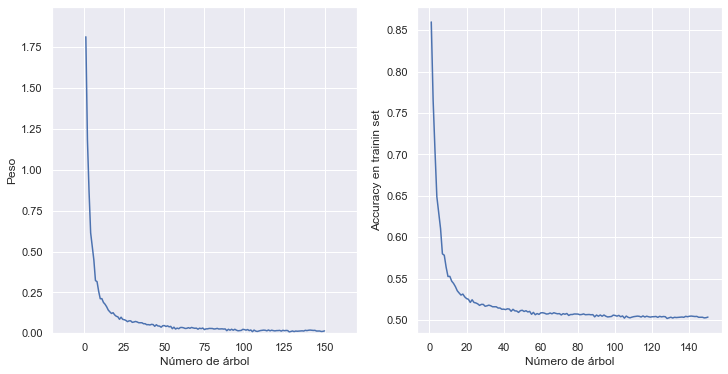

In [8]:
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada_clf)

# En la variable estimator_weights_ esta el peso de cada arbol
pesos = ada_clf.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En estimator_errors_ esta el error que comete cada uno.
errores_arboles = ada_clf.estimator_errors_[:numero_arboles]
accuracy_arboles = 1-errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

5. ¿Le parece relevante la contribución de todos los árboles?¿Cómo se relaciona el accuracy de cada árbol con el peso que le damos en la clasificación final?

6. Veamos cómo cambia el error en el training set y en el test set a medida que agregamos árboles. Para esto vamos a utilizar un metodo llamado `staged_predict`, que nos devuelve la predicción del ensamble en cada instancia en que fuimos agregandole un nuevo estimador.

Text(0.5, 0, 'Número de árboles')

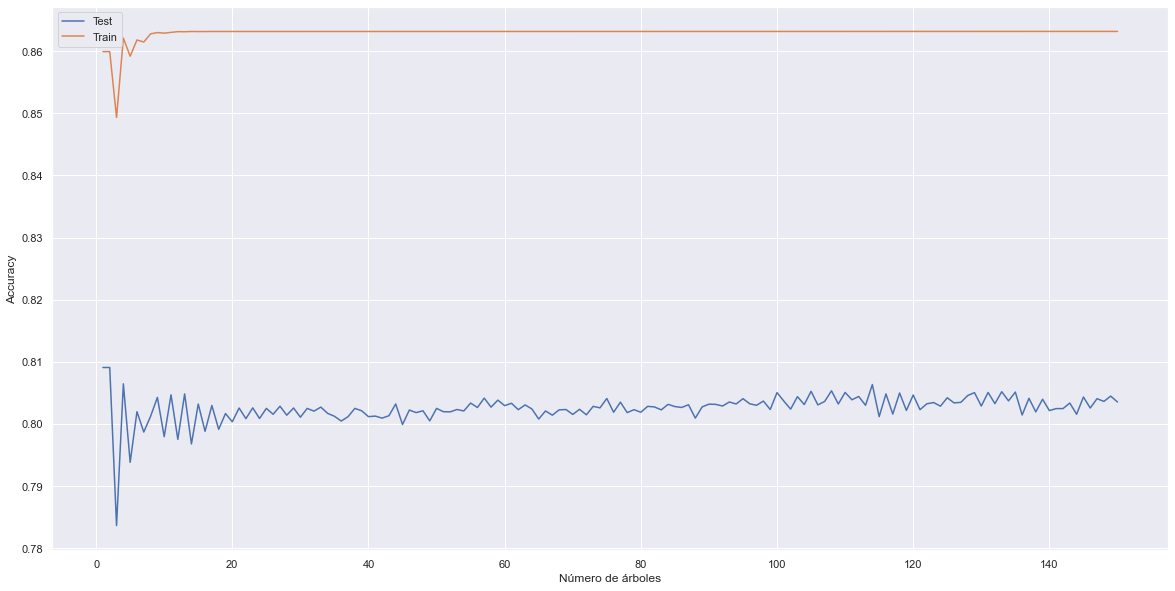

In [15]:
accuracy_test = []
accuracy_train = []
# Calculamos el accuracy sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test,y_test))
    
for prediccion_train in ada_clf.staged_predict(X_train):    
    accuracy_train.append(metrics.accuracy_score(prediccion_train,y_train))

plt.figure(figsize = (20,10))  
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()

plt.ylabel('Accuracy')
plt.xlabel('Número de árboles')

7. Grafiquemos la frontera de decisión del clasificador

/home/esteban/miniconda3/envs/time_series/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


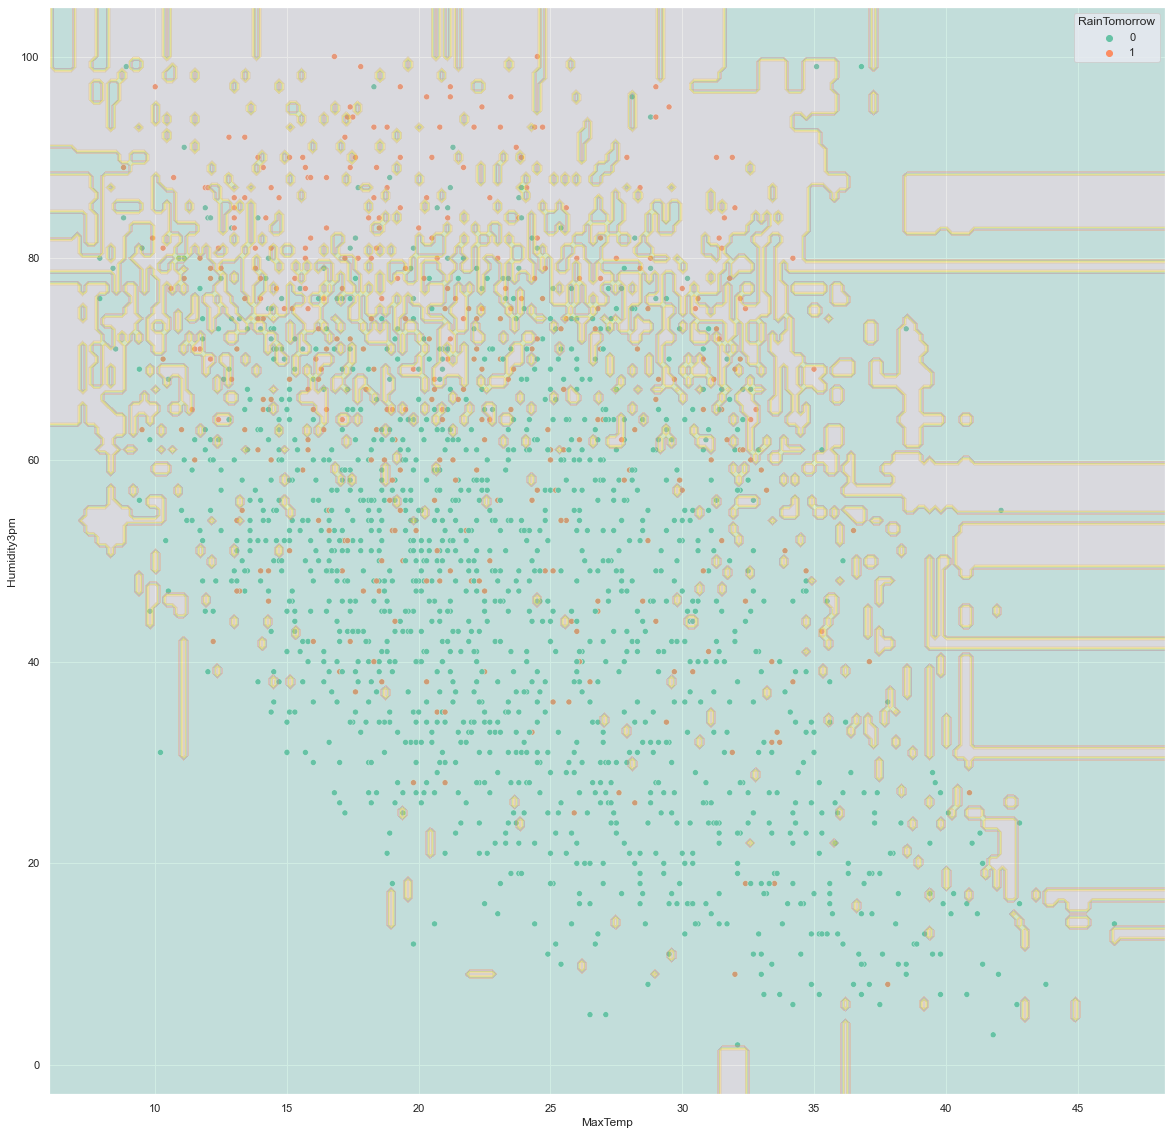

In [19]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (20,20))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
 

plt.show()

8. Repita lo realizado hasta ahora pero utilice árboles de profundidad diez. Preste atención a las curvas de accuracy en train y test y al gráfico de la frontera. ¿Qué le parece que esta sucediendo en este caso?



In [20]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),algorithm='SAMME', n_estimators=150)
# Entrenamos el modelo
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=10),
                   n_estimators=150)

In [21]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.8407782711551356
0.8261408583741662


Text(0.5, 0, 'Número de árbol')

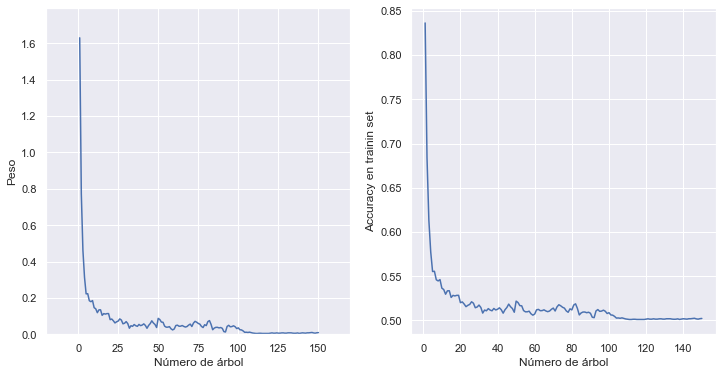

In [22]:
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada_clf)

# En la variable estimator_weights_ esta el peso de cada arbol
pesos = ada_clf.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En estimator_errors_ esta el error que comete cada uno.
errores_arboles = ada_clf.estimator_errors_[:numero_arboles]
accuracy_arboles = 1-errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)
# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

Text(0.5, 0, 'Número de árboles')

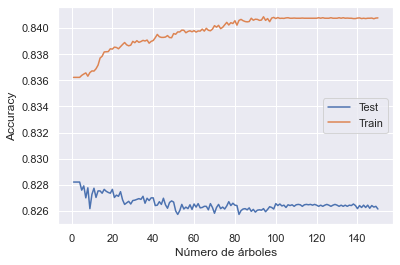

In [23]:
accuracy_test = []
accuracy_train = []
# Calculamos el accuracy sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test,y_test))
    
for prediccion_train in ada_clf.staged_predict(X_train):    
    accuracy_train.append(metrics.accuracy_score(prediccion_train,y_train))
    
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Número de árboles')

In [24]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1)
                             ,algorithm='SAMME'
                             ,n_estimators=150
                            )
# Entrenamos el modelo
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=150)

In [25]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.82977216086632
0.8319558415490879


/home/esteban/miniconda3/envs/time_series/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


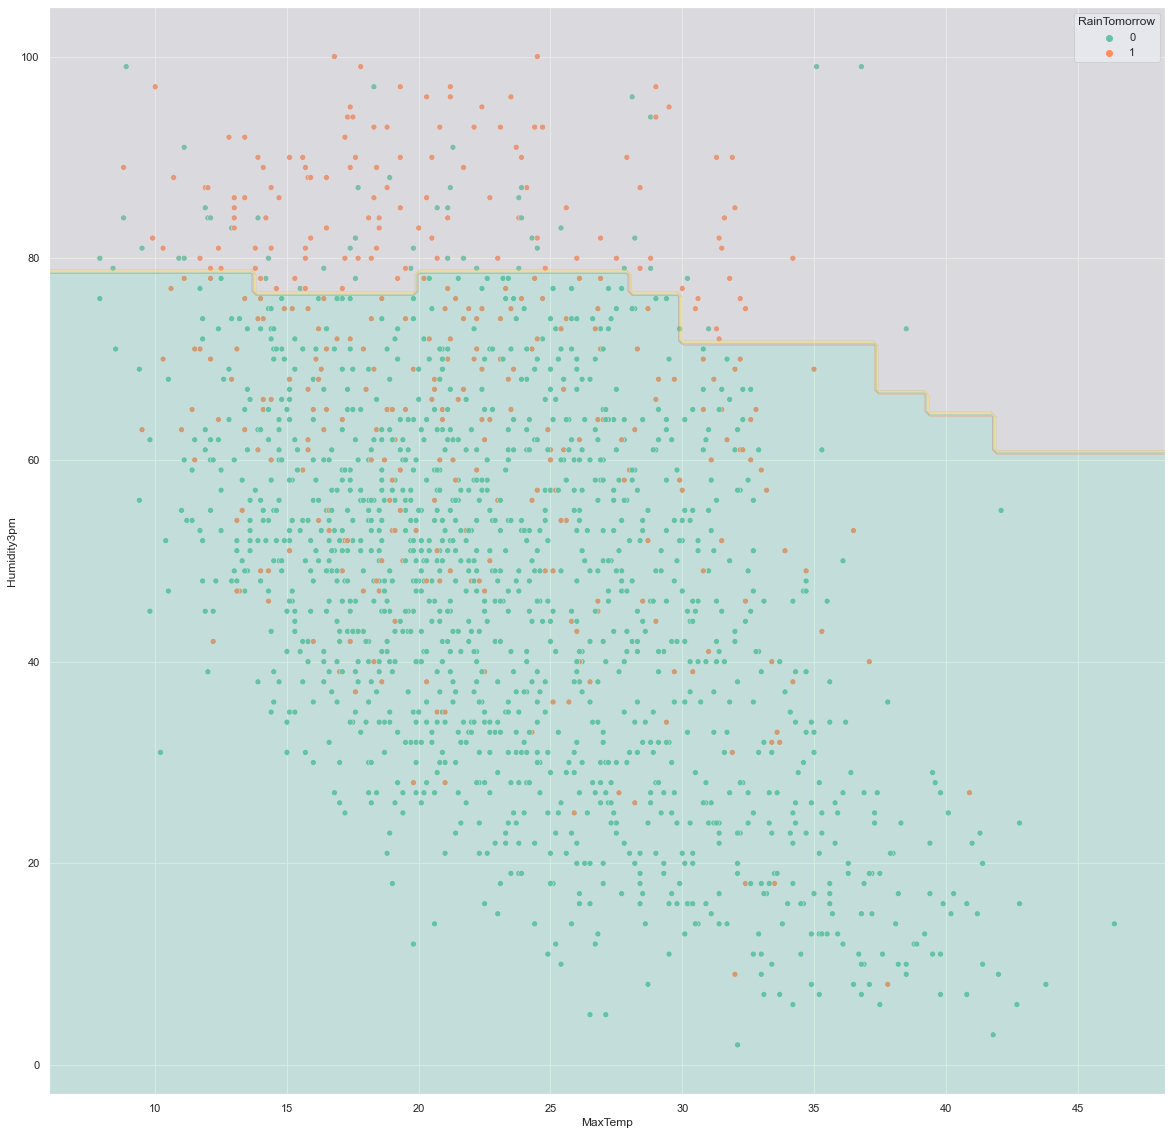

In [26]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (20,20))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')
 

plt.show()

### 2. XGBoost

Instalar y entrenar un modelo con `XGBoost` sobre este dataset. Explorar diferencias y similitudes con `Adaboost`. 

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
# fit model no training data
xgb_clf = XGBClassifier(eval_metric='logloss'
                       )
xgb_clf.fit(X_train, y_train)

/home/esteban/miniconda3/envs/time_series/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [29]:
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.8349842498766556
0.8313654879272684


## 3. LightGBM

In [30]:
import lightgbm as lgb


lgbm_clf = lgb.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

LGBMClassifier()

In [31]:
y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)
print(metrics.accuracy_score(y_train, y_train_pred))
print(metrics.accuracy_score(y_test, y_test_pred))

0.832352903968525
0.8324281244465435
